For this assignment, use the ERA-5 *monthly mean* data at NCAR (DOI: 10.5065/P8GT-0R61) as we did in Module 2.  Feel free to reduce the data to 1 degree resolution if you need to save data download times.


1) Create a dataset that contains the monthly means of Sea Surface Temperature anomalies and total column water vapor from Jan 1979-Dec 2024 over the Pacific Basin (65°N to 65°S, 120°E to 60°W) masked out over land - save this to your computer. The data and land sea mask is available here: [https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means?tab=download](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means?tab=download)


Download ERA5 Monthly Data

In [1]:
# 📦 Import necessary libraries
import cdsapi
import xarray as xr

# 📥 Step 1: Download monthly SST and TCWV from ERA5 (1979–2024) over the Pacific Basin
# This only needs to be run once — comment it out after downloading
c = cdsapi.Client()

#c.retrieve(
 #   'reanalysis-era5-single-levels-monthly-means',
   # {
   #     'variable': ['sea_surface_temperature','total_column_water_vapour'],
    #    'product_type': 'monthly_averaged_reanalysis',
     #   'year':    [str(y) for y in range(1979,2025)],
      #  'month':   [f'{m:02d}' for m in range(1,13)],
       # 'time':    '00:00',
        #'area':    [65,120,-65,-60],  # N, W, S, E
       # 'format':  'netcdf',
    #},
    #'pacific_sst_tcwv_1979_2024.nc'
#)

# 🌍 Step 2: Download land-sea mask (only one time slice needed)
#c.retrieve(
 #   'reanalysis-era5-single-levels',
  #  {
   #     'variable':     'land_sea_mask',
   #     'product_type': 'reanalysis',
   #     'year':         '2020',
   #     'month':        '01',
   #     'day':          '01',
   #     'time':         '00:00',
   #     'area':         [65,120,-65,-60],
   #     'format':       'netcdf',
    #},
    #'lsm.nc'
#)

# 📂 Step 3: Load the datasets

ds  = xr.open_dataset('pacific_sst_tcwv_1979_2024.nc')
ds = ds.rename({'valid_time': 'time'})  # Ensure time dimension is named 'time'
ds = ds.chunk({'time': -1}) 

lsm = xr.open_dataset('lsm.nc')['lsm'].squeeze()

# 🧼 Step 4: Mask out land (keep ocean only where lsm == 0)
sst = ds['sst'].where(lsm == 0)
tcwv = ds['tcwv'].where(lsm == 0)

# 📉 Step 5: Compute monthly SST anomalies (remove monthly climatology)
clim = sst.groupby('time.month').mean('time')
sst_anomaly = sst.groupby('time.month') - clim

# 🧩 Step 6: Combine SST anomalies and TCWV into one dataset
ds_combined = xr.Dataset({
    'sst_anomaly': sst_anomaly,
    'tcwv':        tcwv
})
ds_combined.to_netcdf('pacific_sst_tcwv_anomalies_masked.nc')


Recovering from connection error [HTTPSConnectionPool(host='cds.climate.copernicus.eu', port=443): Read timed out. (read timeout=60)], attempt 1 of 500
Retrying in 120 seconds
Recovering from connection error [('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))], attempt 2 of 500
Retrying in 120 seconds


/home/kiaracr2/envs/xarray-climate/lib/python3.13/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


2)  From the dataset shown in 1, compute anomalies by deseasonalizing the data (remove the mean monthly anomaly from the annual mean from each point) and detrend the data.  

In [2]:
# 📦 Import libraries and functions
import numpy as np
import xarray as xr

# 🧠 Helper: Convert time to float seconds since first timestamp
def _time_as_float(time: xr.DataArray, time_dim: str) -> xr.DataArray:
    return (time - time.isel({time_dim: 0})).astype("timedelta64[s]").astype("int64").astype("float64")

# 📉 Remove linear trend from each grid point
def linear_detrend(obj: xr.DataArray | xr.Dataset, time_dim: str = "time") -> xr.DataArray | xr.Dataset:
    t = _time_as_float(obj[time_dim], time_dim)
    def _detrend_da(da: xr.DataArray) -> xr.DataArray:
        da = da.sortby(time_dim).astype("float32")
        if hasattr(da.data, "chunks"):
            da = da.chunk({time_dim: -1})
        mask = da.notnull()
        t_b = t.broadcast_like(da)
        t_mean_valid = t_b.where(mask).mean(time_dim, skipna=True)
        tc = t_b - t_mean_valid
        num = (da * tc).sum(time_dim, skipna=True)
        den = (tc**2).sum(time_dim, skipna=True)
        slope = xr.where(den > 0, num / den, 0.0)
        ybar = da.mean(time_dim, skipna=True)
        trend = slope * (t_b - t_mean_valid) + ybar
        return (da - trend).astype("float32")
    return obj.map(_detrend_da) if isinstance(obj, xr.Dataset) else _detrend_da(obj)

# 📊 Remove monthly climatology and compute z-scores
def monthly_anom_and_z(
    detr: xr.DataArray | xr.Dataset,
    time_dim: str = "time",
    base_period: tuple[str, str] | None = None,
    ddof: int = 1,
    eps: float = 1e-6,
):
    clim_src = detr if base_period is None else detr.sel({time_dim: slice(*base_period)})
    key = f"{time_dim}.month"
    clim_mean = clim_src.groupby(key).mean(time_dim, skipna=True)
    anom = detr.groupby(key) - clim_mean
    clim_std = clim_src.groupby(key).std(time_dim, skipna=True, ddof=ddof)
    safe_std = xr.where(clim_std > eps, clim_std, np.nan)
    z = anom.groupby(key) / safe_std
    return anom, z

# 📂 Load the masked dataset
ds = xr.open_dataset("pacific_sst_tcwv_anomalies_masked.nc")
ds = ds.chunk({"time": -1})  # Ensure time is a single chunk

detr = linear_detrend(ds[["sst_anomaly", "tcwv"]], time_dim="time")   # or just ds if you want all float vars
anom, z = monthly_anom_and_z(detr, time_dim="time")

print(type(z), list(z.data_vars))   # should show a Dataset with ['sst','tcrw']

<class 'xarray.core.dataset.Dataset'> ['sst_anomaly', 'tcwv']


Then, standardize the SST anomalies. Standardization means subtract the long term mean and divide by the standard deviation, which can be accomplished using the methods described here: 6.3. Preprocessing data — scikit-learn 1.1.2 documentation

In [3]:
# 1️⃣ Import scaler
from sklearn.preprocessing import StandardScaler
import xarray as xr

# 2️⃣ Grab your SST anomalies (after detrending + monthly climatology removal)
#    anom, z = monthly_anom_and_z(detr, time_dim="time")
sst_anom = anom["sst_anomaly"]            # shape: (time, lat, lon)
sst_anom = sst_anom.transpose("time", "latitude", "longitude")

# 3️⃣ Flatten space and drop any grid-points with NaNs
sst2d      = sst_anom.stack(space=("latitude","longitude"))         # (time, space)
sst2d_clean = sst2d.dropna(dim="space", how="any")                 # drop columns with any NaNs

# 4️⃣ Fit & transform with StandardScaler → zero-mean, unit-variance
X          = sst2d_clean.values                                    # ndarray (time, features)
scaler     = StandardScaler()
X_scaled   = scaler.fit_transform(X)

# 5️⃣ Turn the scaled array back into an xarray.DataArray
sst_scaled2d = xr.DataArray(
    X_scaled,
    dims=("time","space"),
    coords={"time": sst2d_clean.time, "space": sst2d_clean.space},
    name="sst_standardized"
)

# 6️⃣ Unstack back to (time, latitude, longitude)
sst_standardized = sst_scaled2d.unstack("space")


3) Perform an EOF analysis on the SST anomalies and plot a map of the first 5 EOFs, following M04N05.

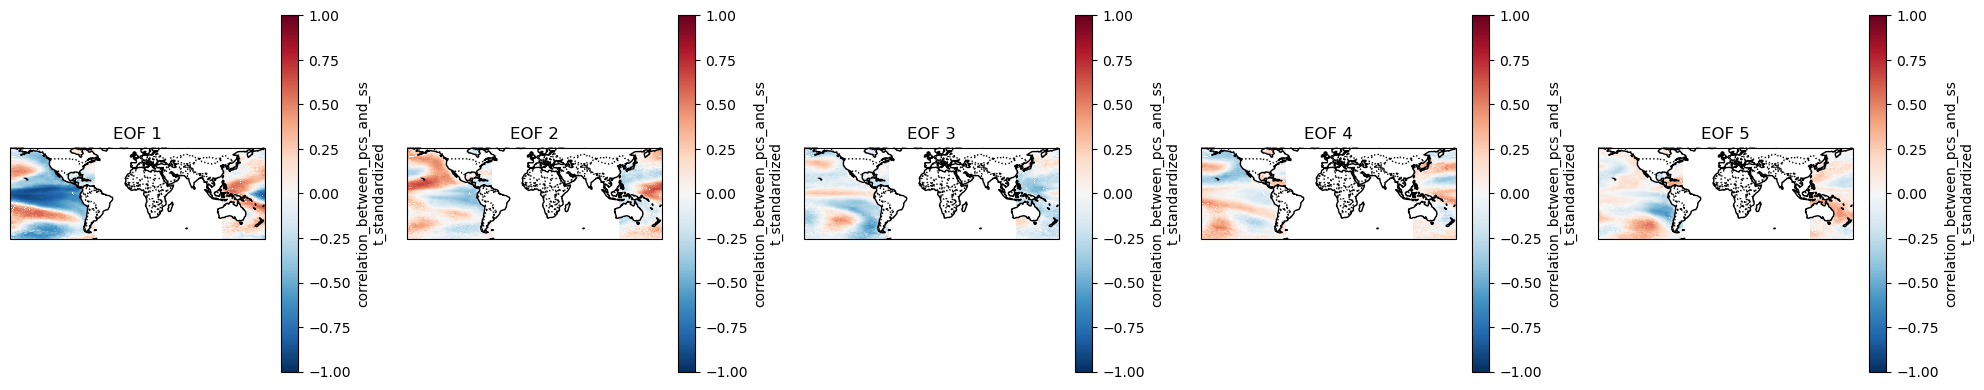

In [4]:
# 📦 EOFSA: Pacific-only, standardized SST anomalies with √cos(lat) weighting

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs, cartopy.feature as cfeature
from eofs.xarray import Eof

# 1️⃣ Subset to Pacific Basin (65°S–65°N, 120°E–60°W)
sst = (
    sst_standardized
    .sortby("latitude")
    .sel(latitude=slice(-65, 65), longitude=slice(120, 300))
)

# 2️⃣ Drop any grid points with NaNs across time
valid = (~np.isnan(sst)).all(dim="time")
sst_clean = sst.where(valid)

# 3️⃣ Compute √cos(lat) weights and broadcast to (lat, lon)
coslat = np.cos(np.deg2rad(sst_clean.latitude))
wgts_1d = np.sqrt(coslat)
wgts_2d, _ = xr.broadcast(wgts_1d, sst_clean.longitude)

# 4️⃣ Run EOFS solver
solver = Eof(sst_clean, weights=wgts_2d)

# 5️⃣ Extract EOFs and PCs
eofs = solver.eofsAsCorrelation(neofs=5)
pcs  = solver.pcs(npcs=5, pcscaling=1)

# 6️⃣ Plot EOFs 1–5
fig, axes = plt.subplots(1, 5, figsize=(20, 4),
                         subplot_kw={"projection": ccrs.PlateCarree()})
for i, ax in enumerate(axes):
    eof = eofs.isel(mode=i)
    eof.plot(ax=ax, transform=ccrs.PlateCarree(),
             cmap="RdBu_r", vmin=-1, vmax=1)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.set_extent([135, 285, -65, 65], crs=ccrs.PlateCarree())
    ax.set_title(f"EOF {i+1}")
plt.tight_layout()
plt.show()




4) Plot the percent of variance explained by the first 10 EOFs.

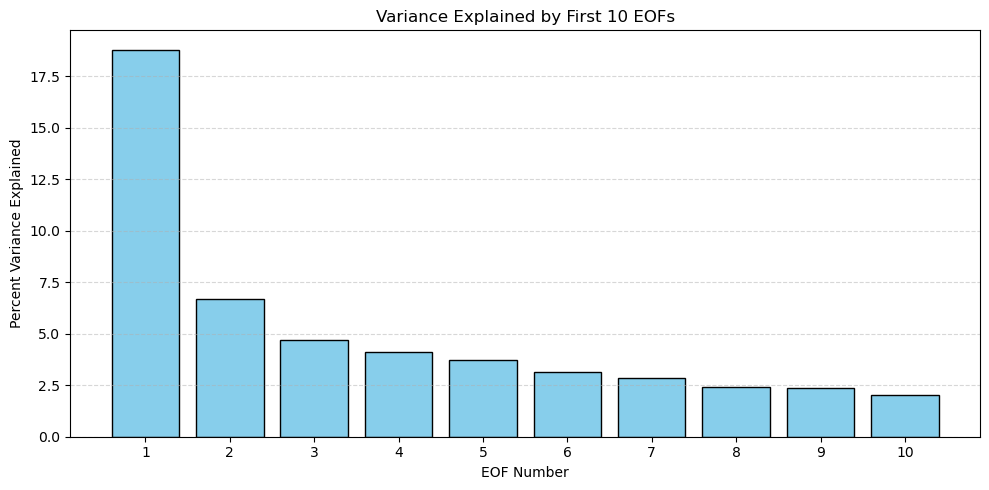

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# 1️⃣ Get variance fractions from EOFS solver
var_frac = solver.varianceFraction()[:10]  # first 10 EOFs
percent_var = var_frac * 100               # convert to percent

# 2️⃣ Plot as a bar chart
plt.figure(figsize=(10, 5))
plt.bar(np.arange(1, 11), percent_var, color="skyblue", edgecolor="black")
plt.xlabel("EOF Number")
plt.ylabel("Percent Variance Explained")
plt.title("Variance Explained by First 10 EOFs")
plt.xticks(np.arange(1, 11))
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


5) Reconstruct the SST field using the first 5 EOFs and plot a map of the Pearson's correlation coefficient ([xarray.corr](https://docs.xarray.dev/en/stable/generated/xarray.corr.html)) of the reconstructed monthly time series and the "observed" SST time series.

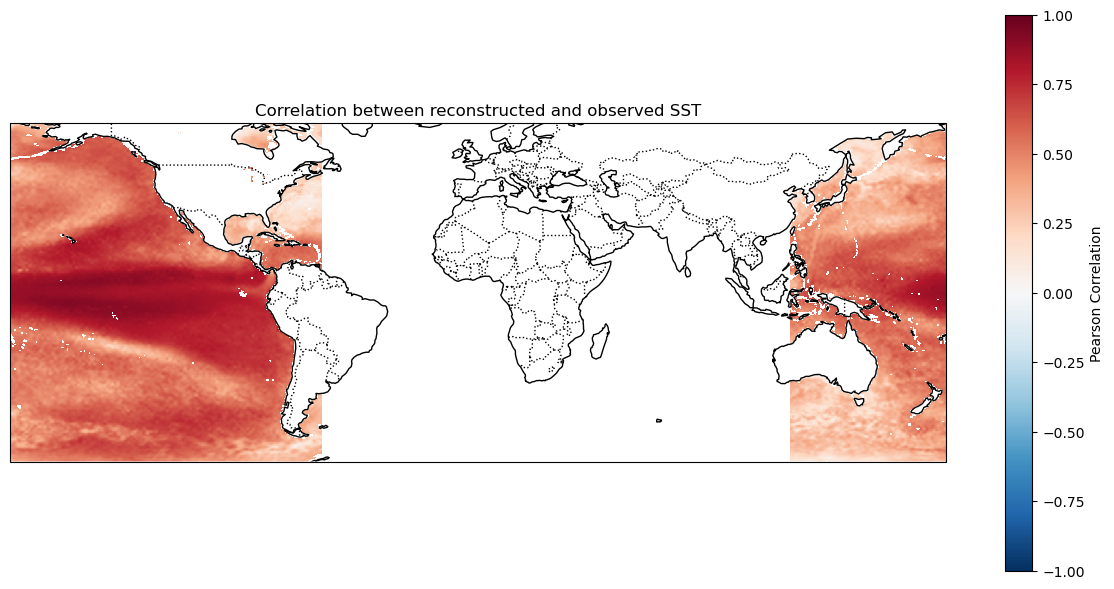

In [6]:
# 📦 Reconstruct SST from first 5 EOFs and plot correlation with observed SST

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs, cartopy.feature as cfeature

# 1️⃣ Get first 5 EOFs and PCs
eofs2d = solver.eofs(neofs=5).stack(space=("latitude", "longitude"))  # (mode, space)
pcs    = solver.pcs(npcs=5, pcscaling=1)                               # (time, mode)

# 2️⃣ Reconstruct SST: matrix multiply PCs × EOFs
sst_recon2d = xr.dot(pcs, eofs2d, dims="mode")                         # (time, space)

# 3️⃣ Flatten observed SST to match (time, space)
sst_obs2d = sst_clean.stack(space=("latitude", "longitude"))
sst_obs2d = sst_obs2d.sel(space=sst_recon2d.space)                     # align space dims

# 4️⃣ Convert to NumPy arrays
X = sst_obs2d.values       # shape: (time, space)
Y = sst_recon2d.values     # shape: (time, space)

# 5️⃣ Compute correlation at each grid point
#    – subtract mean along time
Xc = X - X.mean(axis=0)
Yc = Y - Y.mean(axis=0)

#    – compute correlation: r = cov(X,Y) / (std_X * std_Y)
numerator   = np.sum(Xc * Yc, axis=0)
denominator = np.sqrt(np.sum(Xc**2, axis=0) * np.sum(Yc**2, axis=0))
r = numerator / denominator

# 6️⃣ Wrap back into xarray and unstack to (lat, lon)
corr2d = xr.DataArray(
    r,
    dims=("space",),
    coords={"space": sst_obs2d.space}
)
corr_map = corr2d.unstack("space")

# 7️⃣ Plot correlation map
plt.figure(figsize=(12, 6))
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
corr_map.plot(ax=ax, transform=ccrs.PlateCarree(),
              cmap="RdBu_r", vmin=-1, vmax=1,
              cbar_kwargs={"label": "Pearson Correlation"})
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.set_extent([120, 300, -65, 65], crs=ccrs.PlateCarree())
ax.set_title("Correlation between reconstructed and observed SST")
plt.tight_layout()
plt.show()


6) Compute a map of the Pearson's correlation coefficient between SST EOF1 and monthly mean detrended, deseasonalized, and standardized monthly mean column water vapor anomalies (don't mask these over land for the plot).  See anything interesting? 

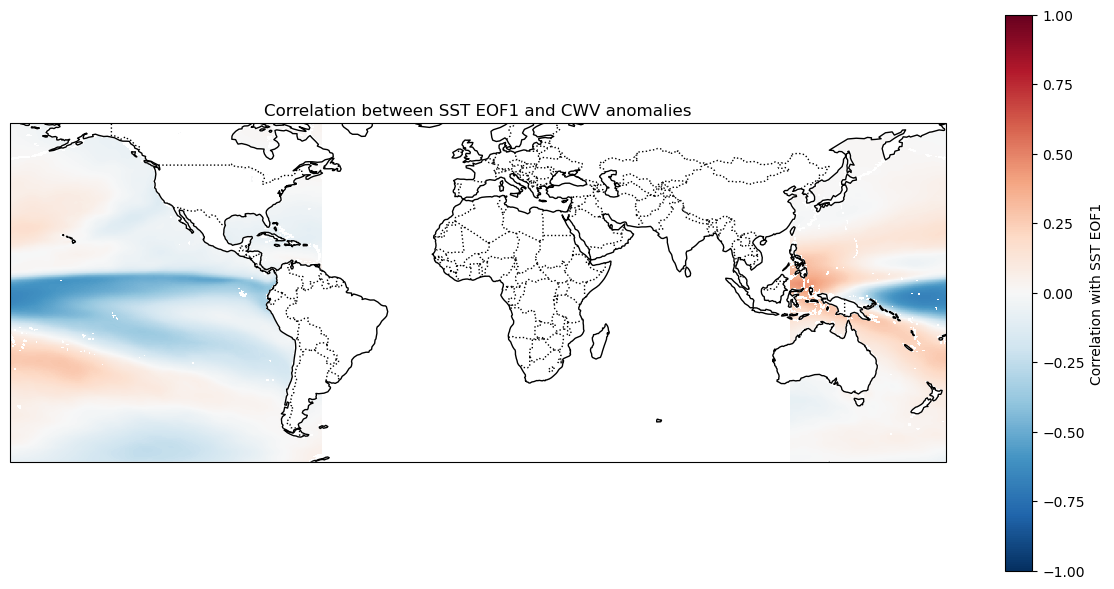

In [11]:
# 🌊📡 Correlation between SST EOF1 and CWV anomalies (tcwv)

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs, cartopy.feature as cfeature

# 1️⃣ Assign CWV anomaly variable
cwv_anom = tcwv  # (time, latitude, longitude)

# 2️⃣ Flatten CWV to (time, space)
cwv2d = cwv_anom.stack(space=("latitude", "longitude"))

# 3️⃣ Drop grid points with NaNs across time
cwv2d_clean = cwv2d.dropna("space", how="any")

# 4️⃣ Convert to NumPy arrays
X = pc1.values                     # shape: (time,)
Y = cwv2d_clean.values.T          # shape: (space, time)

# 5️⃣ Compute correlation at each grid point
Xc = X - X.mean()
Yc = Y - Y.mean(axis=1, keepdims=True)

numerator   = np.dot(Yc, Xc)
denominator = np.sqrt(np.sum(Yc**2, axis=1) * np.sum(Xc**2))
r = numerator / denominator       # shape: (space,)

# 6️⃣ Wrap back to xarray and unstack to (lat, lon)
corr2d = xr.DataArray(
    r,
    dims=("space",),
    coords={"space": cwv2d_clean.space}
)
corr_map = corr2d.unstack("space")

# 7️⃣ Plot correlation map
plt.figure(figsize=(12, 6))
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
corr_map.plot(ax=ax, transform=ccrs.PlateCarree(),
              cmap="RdBu_r", vmin=-1, vmax=1,
              cbar_kwargs={"label": "Correlation with SST EOF1"})
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.set_title("Correlation between SST EOF1 and CWV anomalies")
plt.tight_layout()
plt.show()
